# **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from chembl_webresource_client.new_client import new_client
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from  rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem import AllChem
from DeepPurpose import utils
from DeepPurpose import  DTI as models
import warnings
warnings.filterwarnings("ignore")


# **Exploratory Data Analysis**

In [3]:
df = pd.read_csv('../artifacts/data_ingestion/data/data.csv')

In [4]:
# Display the first few rows
print("\n🟢 ─── Data Preview (Head) ───")
print(df.head())

# Summary statistics
print("\n🟡 ─── Data Summary (Describe) ───")
print(df.describe(include='all').transpose())

# Dataframe info
print("\n🔵 ─── Data Info ───")
df.info()

# Shape of the dataframe
print("\n🟠 ─── Data Shape ───")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Column names
print("\n🟣 ─── Column Names ───")
print(", ".join(df.columns))

# Data types of columns
print("\n🔴 ─── Column Data Types ───")
for col, dtype in zip(df.columns, df.dtypes):
    print(f"{col}: {dtype}")

# Count of missing values
print("\n🟡 ─── Missing Values ───")
missing = df.isnull().sum()
print(missing[missing > 0].to_string() if missing.sum() > 0 else "No missing values ✅")



🟢 ─── Data Preview (Head) ───
  molecule_chembl_id standard_type  standard_value standard_units  \
0       chembl113081          ic50        100000.0             nm   
1       chembl324340          ic50          2500.0             nm   
2       chembl324340          ic50         50000.0             nm   
3       chembl109600          ic50          9000.0             nm   
4       chembl357278          ic50          4000.0             nm   

  target_chembl_id                   pref_name  
0       chembl1806  dna topoisomerase ii alpha  
1       chembl3921                  heparanase  
2    chembl3879801          non-protein target  
3       chembl3921                  heparanase  
4       chembl4632       palmitoyl-coa oxidase  

🟡 ─── Data Summary (Describe) ───
                         count   unique           top      freq  \
molecule_chembl_id    10880154  1666658   chembl53463      6841   
standard_type         10880154        7       potency   4308761   
standard_value      1088

In [5]:
# check unique standard units and types

print("\n🟢 ─── Unique Standard Units ───")
print(df['standard_units'].unique())

print("\n🟢 ─── Unique Types ───")
print(df['standard_type'].unique())


🟢 ─── Unique Standard Units ───
['nm']

🟢 ─── Unique Types ───
['ic50' 'ec50' 'mic' 'ki' 'gi50' 'ac50' 'potency']


In [6]:
# see number of unique drugs and target proteins
print("\n🟠 ─── Unique Drugs ───")
print(f"Drugs: {df['molecule_chembl_id'].nunique()}")
print("\n🟠 ─── Unique Target Proteins ───")
print(f"Target Proteins: {df['target_chembl_id'].nunique()}")


🟠 ─── Unique Drugs ───
Drugs: 1666658

🟠 ─── Unique Target Proteins ───
Target Proteins: 10164


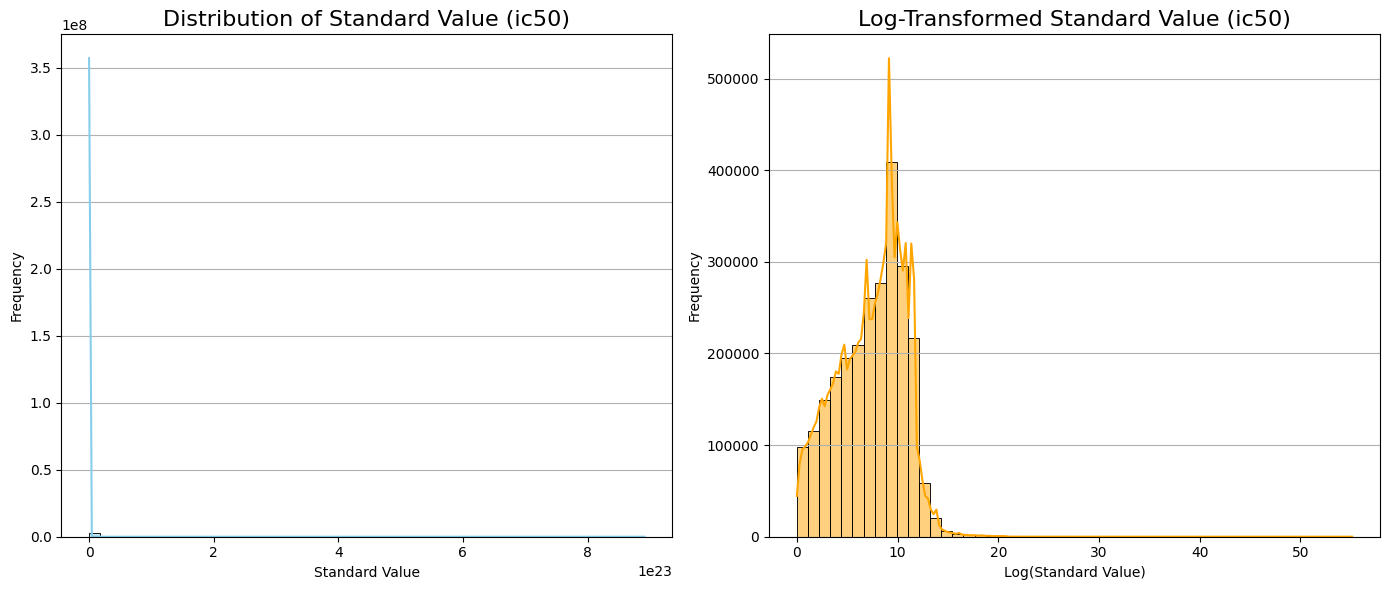

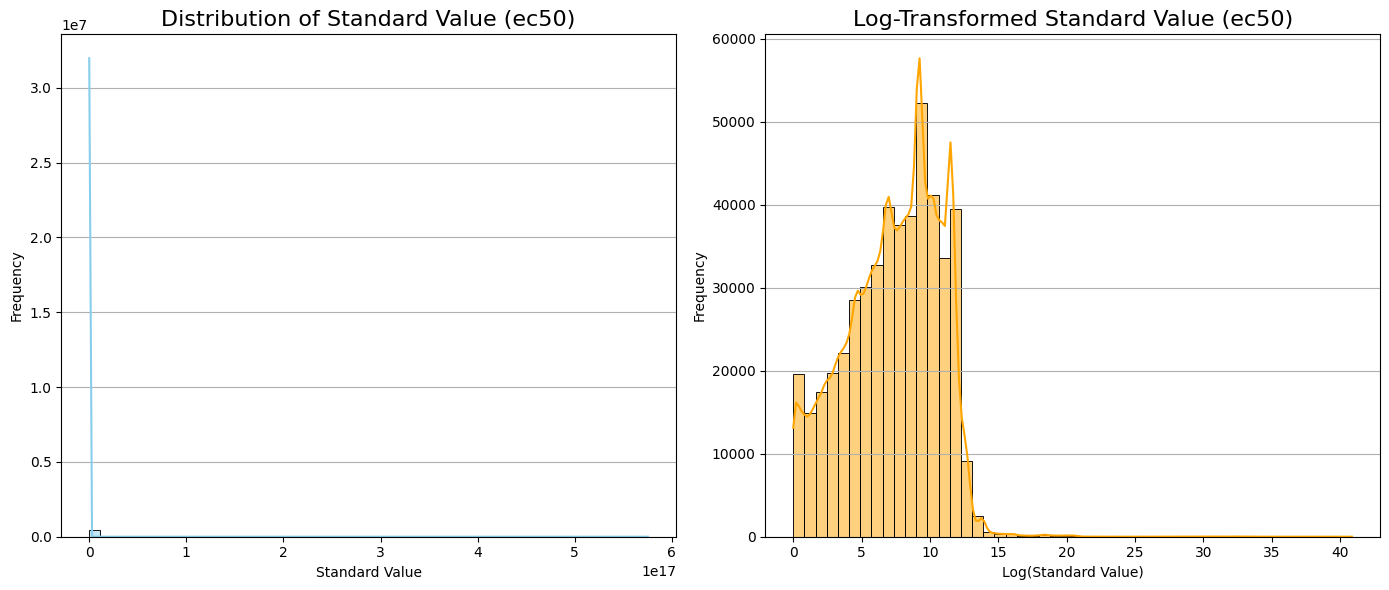

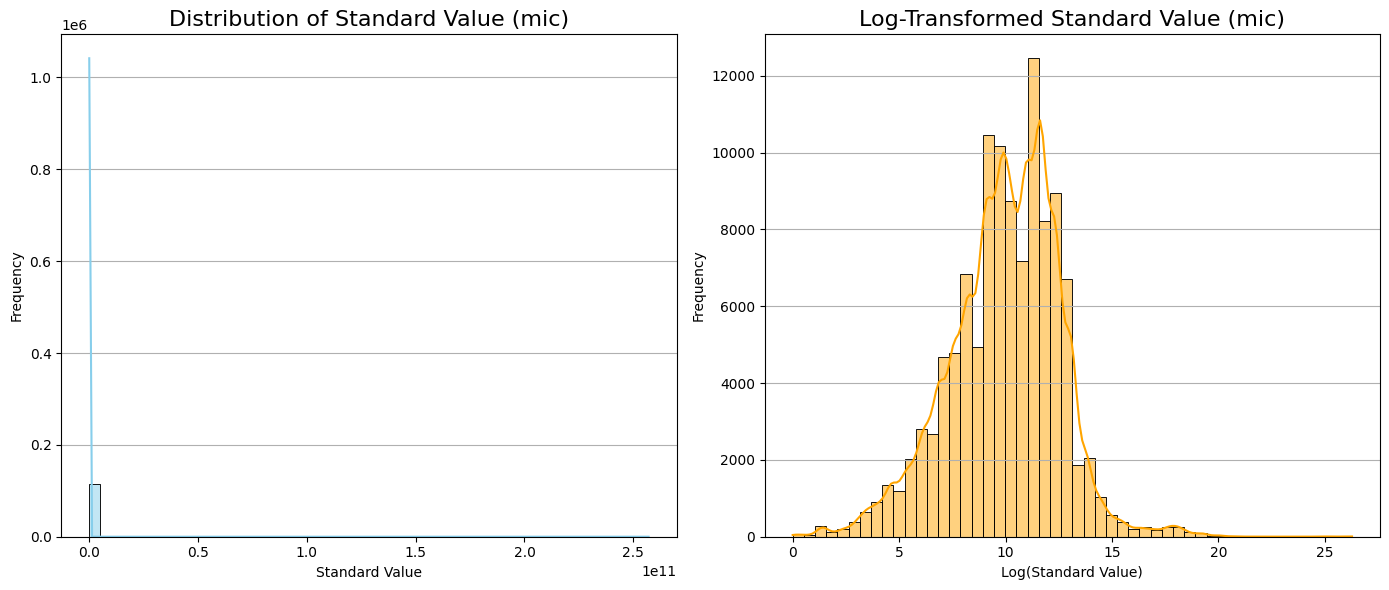

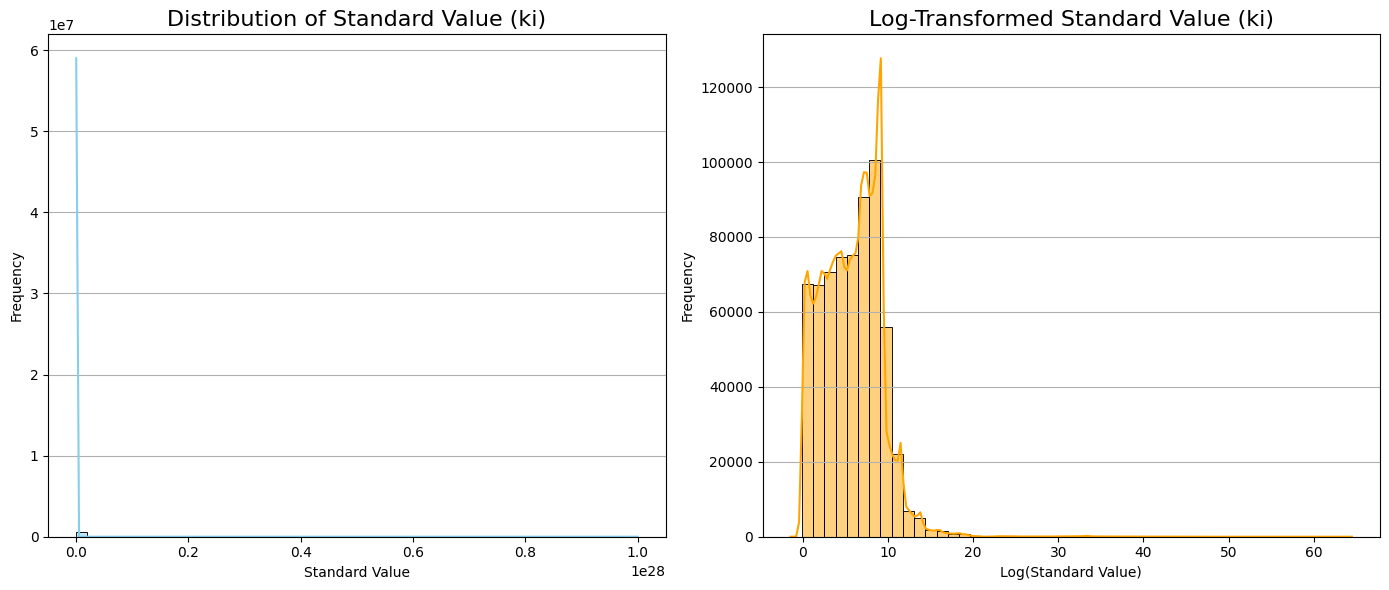

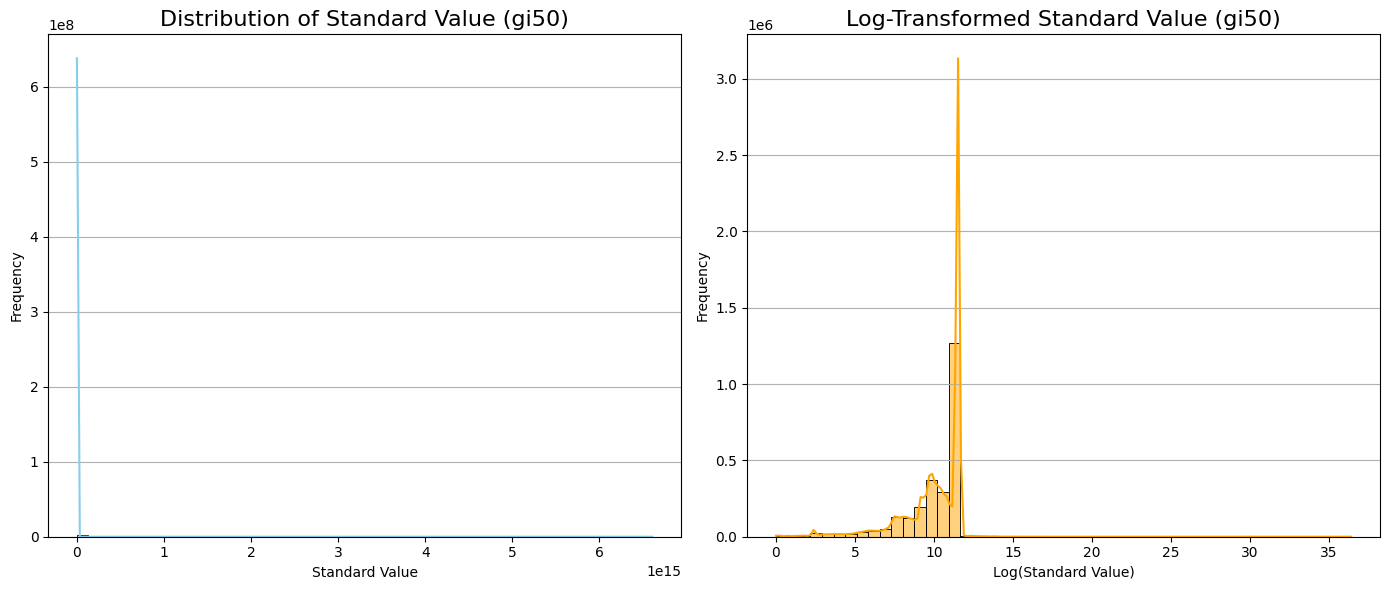

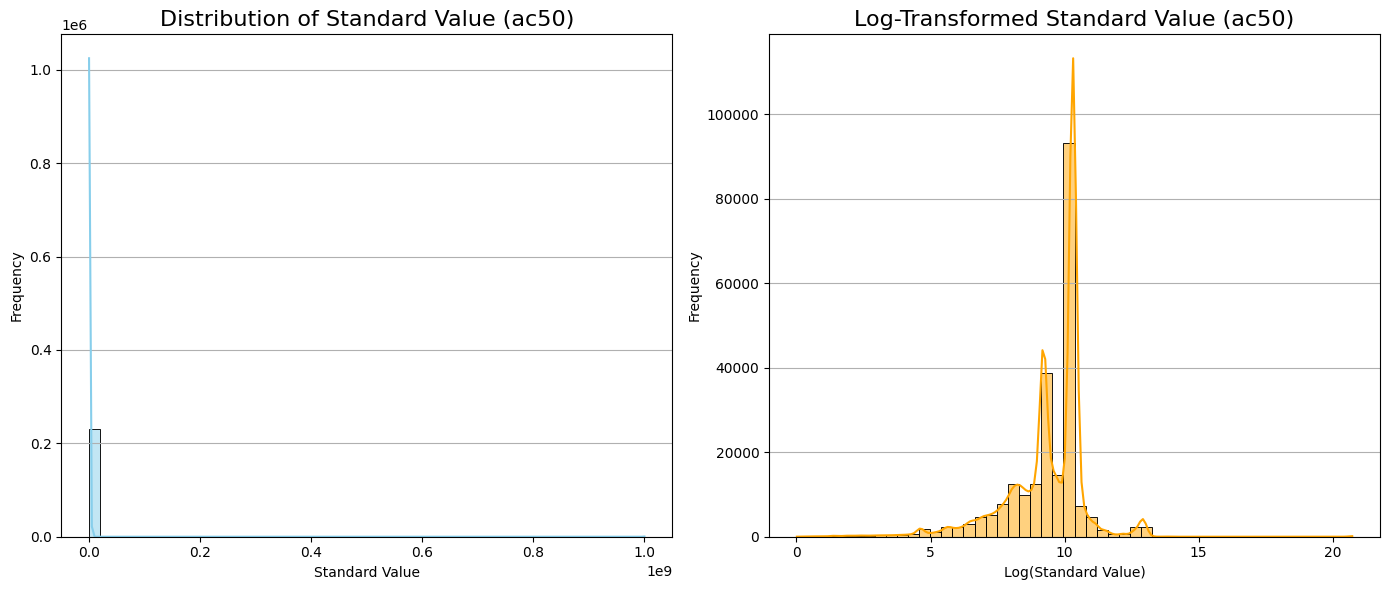

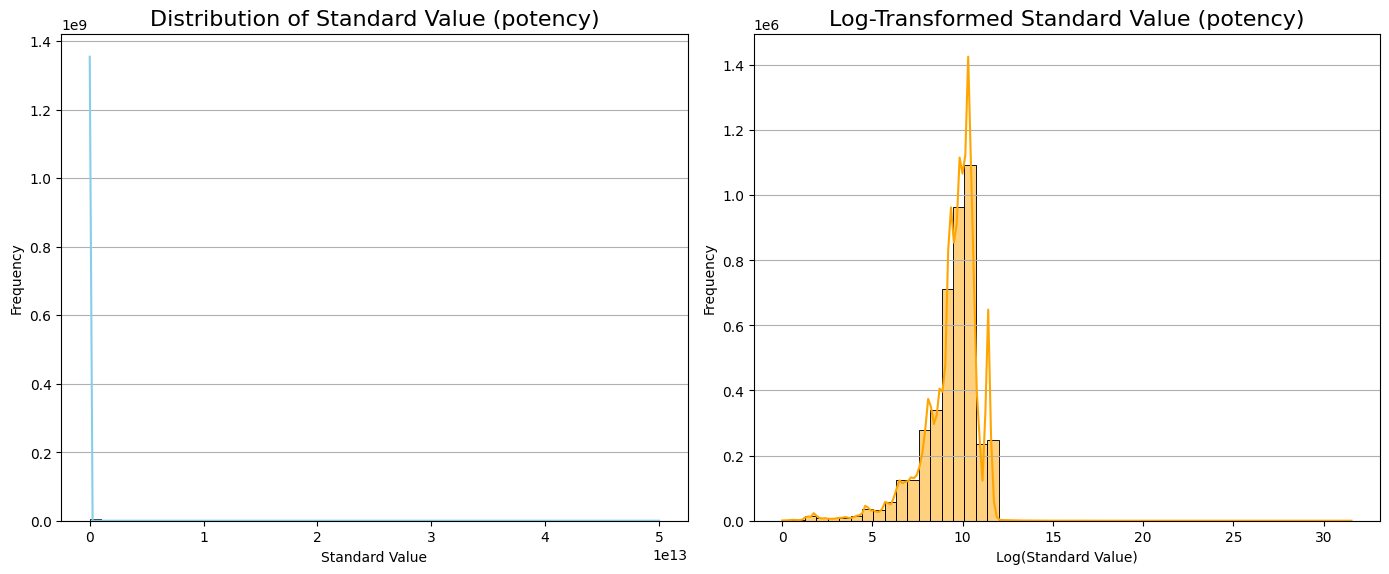

In [7]:
# distribution of standard values for each standard type

standard_types = df['standard_type'].unique()

for stype in standard_types:
    subset = df[df['standard_type'] == stype]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Raw Distribution
    sns.histplot(subset['standard_value'], bins=50, kde=True, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Distribution of Standard Value ({stype})', fontsize=16)
    axes[0].set_xlabel('Standard Value')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y')

    # Log-Transformed Distribution
    sns.histplot(np.log1p(subset['standard_value']), bins=50, kde=True, color='orange', ax=axes[1])
    axes[1].set_title(f'Log-Transformed Standard Value ({stype})', fontsize=16)
    axes[1].set_xlabel('Log(Standard Value)')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y')

    plt.tight_layout()
    plt.show()


🟠 ─── Top 10 Frequent Molecules ───
molecule_chembl_id
chembl53463     6841
chembl98        4539
chembl428647    4039
chembl185       3471
chembl44657     2709
chembl20        2548
chembl76        2434
chembl67        2231
chembl65        2220
chembl1336      2165
Name: count, dtype: int64


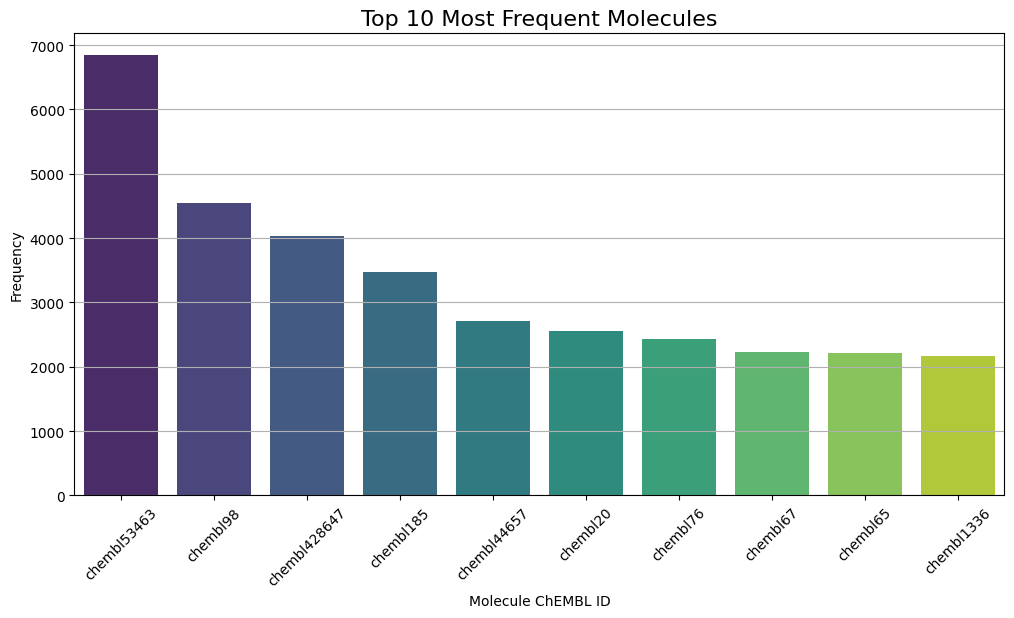

In [8]:
# Top 10 most frequent molecules

print("\n🟠 ─── Top 10 Frequent Molecules ───")
top_molecules = df['molecule_chembl_id'].value_counts().head(10)
print(top_molecules)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_molecules.index, y=top_molecules.values, palette='viridis')
plt.title('Top 10 Most Frequent Molecules', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Molecule ChEMBL ID')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()


🟠 ─── Top 10 Frequent Targets ───
target_chembl_id
chembl612545     932494
chembl364        377434
chembl1075138    345078
chembl3879801    130751
chembl1293278    128009
chembl1741209    122559
chembl5391       116817
chembl1784       109333
chembl1293224     95115
chembl392         94214
Name: count, dtype: int64


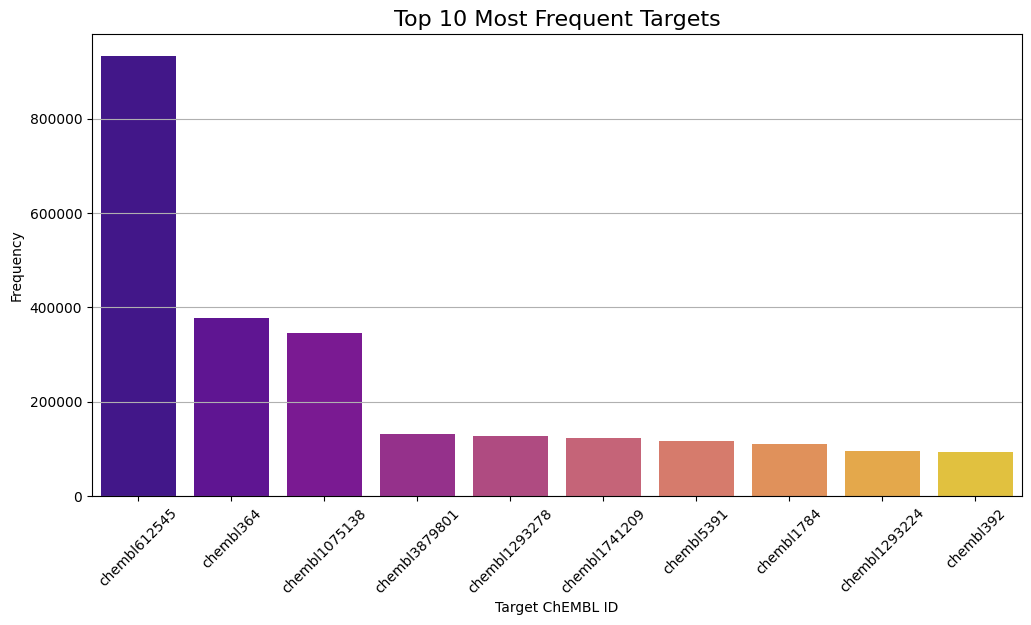

In [9]:
# Top 10 most frequent targets

print("\n🟠 ─── Top 10 Frequent Targets ───")
top_targets = df['target_chembl_id'].value_counts().head(10)
print(top_targets)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_targets.index, y=top_targets.values, palette='plasma')
plt.title('Top 10 Most Frequent Targets', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Target ChEMBL ID')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# **Feature Engineering**

In [10]:
# using a small subset of the data from now onwards (just for this notebook experimentation) for faster computation

df = df.sample(100, random_state=42)
df.shape

(100, 6)

In [11]:
# 🚀 Step 1: Convert ChEMBL IDs to SMILES (Molecules)
print("\n🔹 Converting ChEMBL IDs (Molecules) to SMILES...")

# Initialize ChEMBL client
molecule = new_client.molecule

# Function to get SMILES from ChEMBL ID
def get_smiles(chembl_id):
    """Fetch SMILES for molecules from ChEMBL ID"""
    try:
        res = molecule.get(chembl_id)
        if res and 'molecule_structures' in res and res['molecule_structures']:
            return res['molecule_structures']['canonical_smiles']
        return None
    except:
        return None

# Map molecule ChEMBL IDs to SMILES
tqdm.pandas()
df['mol_SMILES'] = df['molecule_chembl_id'].progress_apply(lambda x: get_smiles(x))


🔹 Converting ChEMBL IDs (Molecules) to SMILES...


100%|██████████| 100/100 [00:00<00:00, 799.10it/s]


In [12]:
# 🚀 Step 2: Convert ChEMBL Target IDs to Sequences/Descriptions
print("\n🔹 Converting Target ChEMBL IDs to Sequences/Descriptions...")

# Initialize ChEMBL client for targets
target = new_client.target_component

# Function to get protein sequences or descriptions for targets
def get_target_info(chembl_id):
    """Fetch target info (protein sequence or description) from ChEMBL ID"""
    try:
        res = target.filter(target_chembl_id=chembl_id)
        if res:
            for item in res:
                if 'sequence' in item and item['sequence']:
                    return item['sequence']  # Return protein sequence if available
                elif 'description' in item:
                    return item['description']  # Fallback to description
        return None
    except Exception as e:
        print(f"Error fetching target info for {chembl_id}: {e}")
        return None

# Map target ChEMBL IDs to sequences/descriptions
tqdm.pandas()
df['target_info'] = df['target_chembl_id'].progress_apply(get_target_info)



🔹 Converting Target ChEMBL IDs to Sequences/Descriptions...


100%|██████████| 100/100 [00:00<00:00, 149.62it/s]


In [13]:
df.head()

,molecule_chembl_id,standard_type,standard_value,standard_units,target_chembl_id,pref_name,mol_SMILES,target_info
9189478,chembl3604471,ic50,177.0,nm,chembl394,hct-116,CC(N)c1csc(/C=N/Nc2ncnc3sc(C(C)(C)C)cc23)n1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
4164007,chembl1327079,potency,2133.1,nm,chembl5567,luciferin 4-monooxygenase,Br.Cc1ccc(SCc2cn3c(C)csc3n2)cc1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
10713522,chembl1433,ac50,30000.0,nm,chembl259,melanocortin receptor 4,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
1813801,chembl1431679,potency,25929.0,nm,chembl612545,unchecked,Cc1cc(=O)oc2cc(NC(S)=NNC(=O)c3c(Cl)cnn3C)ccc12,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
10132157,chembl359744,ic50,670.0,nm,chembl395,hepg2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...


In [14]:
df.isnull().sum()

molecule_chembl_id    0
standard_type         0
standard_value        0
standard_units        0
target_chembl_id      0
pref_name             0
mol_SMILES            0
target_info           0
dtype: int64

In [15]:
df.dropna(inplace=True)

In [16]:
df.reset_index(drop=True, inplace=True)
df.head()

,molecule_chembl_id,standard_type,standard_value,standard_units,target_chembl_id,pref_name,mol_SMILES,target_info
0,chembl3604471,ic50,177.0,nm,chembl394,hct-116,CC(N)c1csc(/C=N/Nc2ncnc3sc(C(C)(C)C)cc23)n1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
1,chembl1327079,potency,2133.1,nm,chembl5567,luciferin 4-monooxygenase,Br.Cc1ccc(SCc2cn3c(C)csc3n2)cc1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
2,chembl1433,ac50,30000.0,nm,chembl259,melanocortin receptor 4,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
3,chembl1431679,potency,25929.0,nm,chembl612545,unchecked,Cc1cc(=O)oc2cc(NC(S)=NNC(=O)c3c(Cl)cnn3C)ccc12,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...
4,chembl359744,ic50,670.0,nm,chembl395,hepg2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...


In [17]:
# drop unnecessary columns
df.drop(columns=['standard_units'], inplace=True)

In [18]:
df["standard_type"].unique()

array(['ic50', 'potency', 'ac50', 'gi50', 'ec50', 'ki', 'mic'],
      dtype=object)

In [19]:
# create seperate dfs for each standard type (keep only necessary ones)
df_ic50 = df[df['standard_type'] == 'ic50'].reset_index(drop=True)
df_ic50.rename(columns={'standard_value': 'ic50'}, inplace=True)
df_ic50.drop(columns=['standard_type'], inplace=True)
df_ec50 = df[df['standard_type'] == 'ec50'].reset_index(drop=True)
df_ec50.rename(columns={'standard_value': 'ec50'}, inplace=True)
df_ec50.drop(columns=['standard_type'], inplace=True)
df_ki = df[df['standard_type'] == 'ki'].reset_index(drop=True)
df_ki.rename(columns={'standard_value': 'ki'}, inplace=True)
df_ki.drop(columns=['standard_type'], inplace=True)

In [20]:
# scale the values 

scaler = MinMaxScaler(feature_range=(0, 100))
df_ic50['ic50'] = scaler.fit_transform(df_ic50[['ic50']])
df_ec50['ec50'] = scaler.fit_transform(df_ec50[['ec50']])
df_ki['ki'] = scaler.fit_transform(df_ki[['ki']])

In [21]:
# add mol col to the dfs

PandasTools.AddMoleculeColumnToFrame(df_ic50, smilesCol='mol_SMILES', molCol='mol')
PandasTools.AddMoleculeColumnToFrame(df_ec50, smilesCol='mol_SMILES', molCol='mol')
PandasTools.AddMoleculeColumnToFrame(df_ki, smilesCol='mol_SMILES', molCol='mol')

,molecule_chembl_id,ic50,target_chembl_id,pref_name,mol_SMILES,target_info,mol
0,chembl3604471,0.096741,chembl394,hct-116,CC(N)c1csc(/C=N/Nc2ncnc3sc(C(C)(C)C)cc23)n1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
1,chembl359744,0.369120,chembl395,hepg2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
2,chembl311498,2.927158,chembl612545,unchecked,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@@H](O)C2,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
3,chembl1738797,0.000000,chembl4247,alk tyrosine kinase receptor,CCc1cc2c(cc1N1CCC(N3CCOCC3)CC1)C(C)(C)c1[nH]c3...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
4,chembl208360,5.523870,chembl3816,cytosolic phospholipase a2,CCCCCCCCc1ccc(OCC(=O)Cn2ccc3c(C(=O)O)cccc32)cc1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
5,chembl454617,2.153669,chembl1907602,cyclin-dependent kinase 1/cyclin b1,CC[C@H](CO)Nc1nc(NCc2ccccn2)c2ncn(C(C)C)c2n1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
6,chembl300624,0.280721,chembl2592,adenosine a2b receptor,Cn1c(-c2cccc(F)c2)nc2c(N)nc(C#CC(C)(C)O)nc21,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
7,chembl51485,0.540392,chembl203,epidermal growth factor receptor erbb1,CN1CCN(CCCNc2ncc3cc(-c4c(Cl)cccc4Cl)c(NC(=O)NC...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
8,chembl3217279,100.000000,chembl613493,vaccinia virus,O=C([O-])CC(SCCCOC[C@H]1O[C@@H](O[C@H]2[C@H](O...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,
9,chembl3422914,1.822174,chembl3879801,non-protein target,O=C(/C=C1/C(=O)N(Cc2ccc(C(F)(F)F)cc2)c2ccccc21...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,

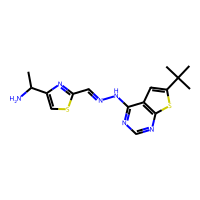
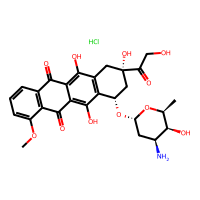
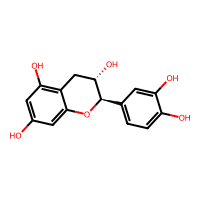
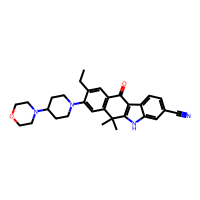
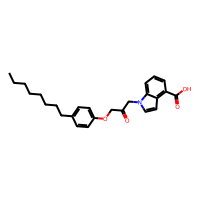
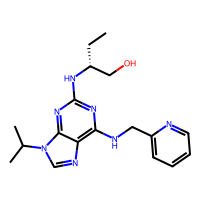
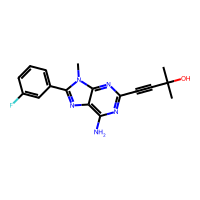
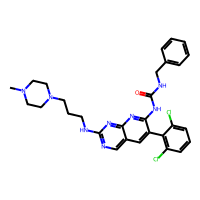
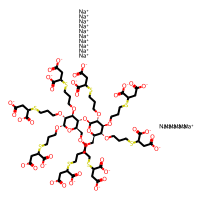
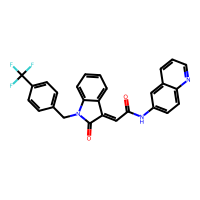
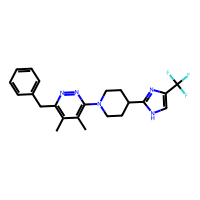
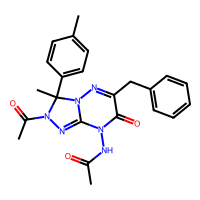
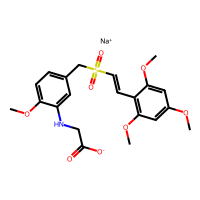
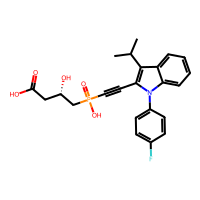
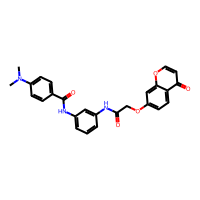
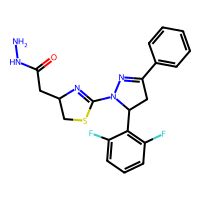
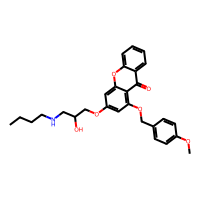
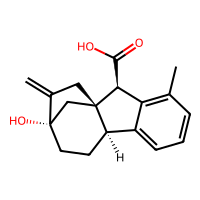
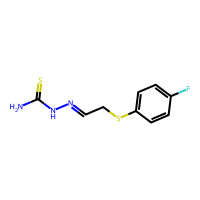
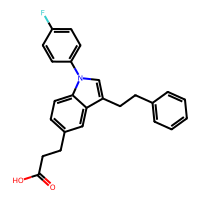
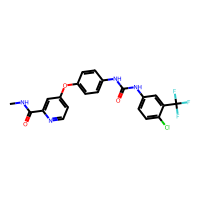
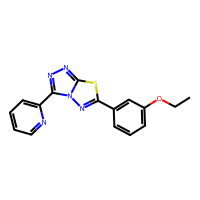
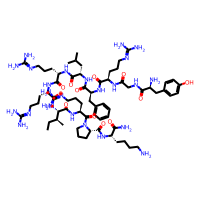

In [22]:
df_ic50

,molecule_chembl_id,ic50,target_chembl_id,pref_name,mol_SMILES,target_info,mol,Number_of_Atoms
0,chembl3604471,0.096741,chembl394,hct-116,CC(N)c1csc(/C=N/Nc2ncnc3sc(C(C)(C)C)cc23)n1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,24
1,chembl359744,0.369120,chembl395,hepg2,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,40
2,chembl311498,2.927158,chembl612545,unchecked,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@@H](O)C2,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,21
3,chembl1738797,0.000000,chembl4247,alk tyrosine kinase receptor,CCc1cc2c(cc1N1CCC(N3CCOCC3)CC1)C(C)(C)c1[nH]c3...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,36
4,chembl208360,5.523870,chembl3816,cytosolic phospholipase a2,CCCCCCCCc1ccc(OCC(=O)Cn2ccc3c(C(=O)O)cccc32)cc1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,31
5,chembl454617,2.153669,chembl1907602,cyclin-dependent kinase 1/cyclin b1,CC[C@H](CO)Nc1nc(NCc2ccccn2)c2ncn(C(C)C)c2n1,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,26
6,chembl300624,0.280721,chembl2592,adenosine a2b receptor,Cn1c(-c2cccc(F)c2)nc2c(N)nc(C#CC(C)(C)O)nc21,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,24
7,chembl51485,0.540392,chembl203,epidermal growth factor receptor erbb1,CN1CCN(CCCNc2ncc3cc(-c4c(Cl)cccc4Cl)c(NC(=O)NC...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,40
8,chembl3217279,100.000000,chembl613493,vaccinia virus,O=C([O-])CC(SCCCOC[C@H]1O[C@@H](O[C@H]2[C@H](O...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,135
9,chembl3422914,1.822174,chembl3879801,non-protein target,O=C(/C=C1/C(=O)N(Cc2ccc(C(F)(F)F)cc2)c2ccccc21...,MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...,,35

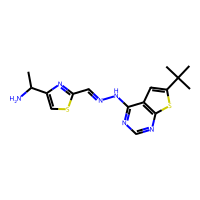
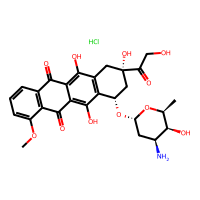
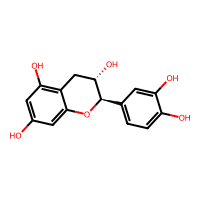
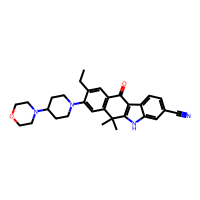
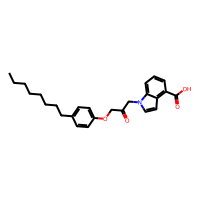
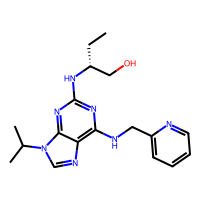
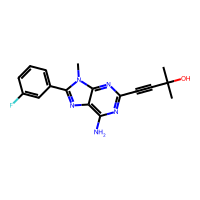
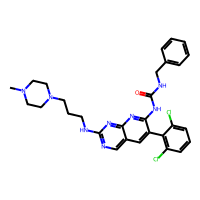
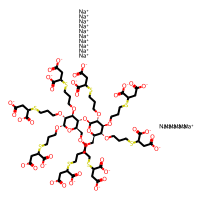
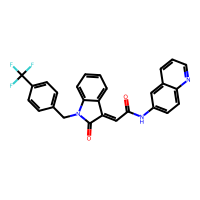
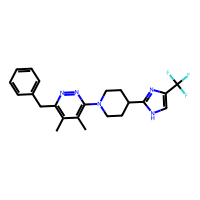
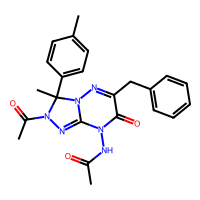
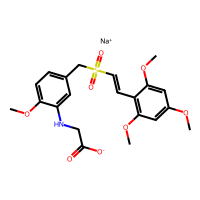
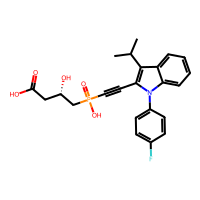
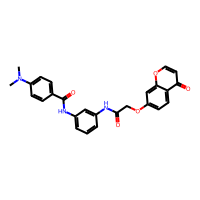
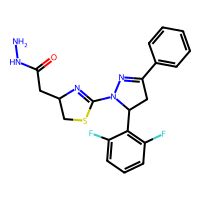
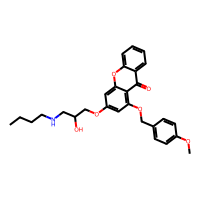
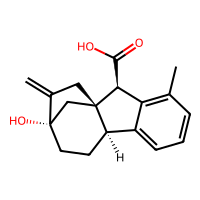
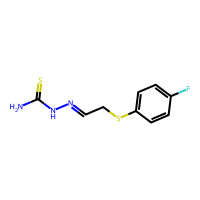
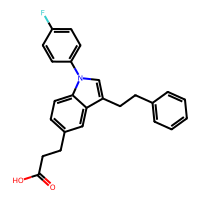
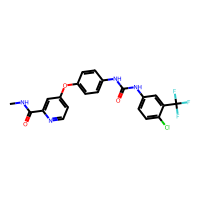
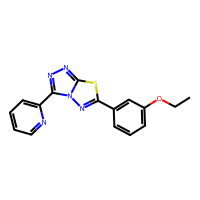
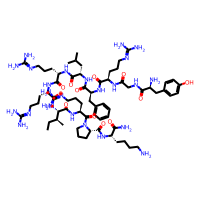

In [23]:
# get the number of atoms in the molecule
df_ic50['Number_of_Atoms'] = df_ic50['mol_SMILES'].map(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
df_ec50['Number_of_Atoms'] = df_ec50['mol_SMILES'].map(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
df_ki['Number_of_Atoms'] = df_ki['mol_SMILES'].map(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
df_ic50

In [24]:
# create splits for training and testing
from sklearn.model_selection import train_test_split
df_ic50_train, df_ic50_test = train_test_split(df_ic50, test_size=0.2, random_state=42)
df_ec50_train, df_ec50_test = train_test_split(df_ec50, test_size=0.2, random_state=42)
df_ki_train, df_ki_test = train_test_split(df_ki, test_size=0.2, random_state=42)

In [25]:
# change dtype of mol_SMILES to '<U92' and of target_info to '<U2549'
df_ic50_train['mol_SMILES'] = df_ic50_train['mol_SMILES'].astype('<U92')
df_ic50_train['target_info'] = df_ic50_train['target_info'].astype('<U2549')
df_ic50_test['mol_SMILES'] = df_ic50_test['mol_SMILES'].astype('<U92')
df_ic50_test['target_info'] = df_ic50_test['target_info'].astype('<U2549')

df_ec50_train['mol_SMILES'] = df_ec50_train['mol_SMILES'].astype('<U92')
df_ec50_train['target_info'] = df_ec50_train['target_info'].astype('<U2549')
df_ec50_test['mol_SMILES'] = df_ec50_test['mol_SMILES'].astype('<U92')
df_ec50_test['target_info'] = df_ec50_test['target_info'].astype('<U2549')

df_ki_train['mol_SMILES'] = df_ki_train['mol_SMILES'].astype('<U92')
df_ki_train['target_info'] = df_ki_train['target_info'].astype('<U2549')
df_ki_test['mol_SMILES'] = df_ki_test['mol_SMILES'].astype('<U92')
df_ki_test['target_info'] = df_ki_test['target_info'].astype('<U2549')

# **Model Training (ic50)**

In [32]:
drug_encoding = 'Transformer'
target_encoding = 'CNN'

In [33]:
drugs = df_ic50_train['mol_SMILES'].values
targets = df_ic50_train['target_info'].values
y = df_ic50_train['ic50'].values

In [34]:
train, val, test = utils.data_process(drugs, targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2],
                                random_seed = 1)

Drug Target Interaction Prediction Mode...
in total: 18 drug-target pairs
encoding drug...
unique drugs: 18
encoding protein...
unique target sequence: 1
splitting dataset...
Done.


In [35]:
config = utils.generate_config(drug_encoding = drug_encoding,
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512],
                         train_epoch = 100,
                         LR = 0.001,
                         batch_size = 128,
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )

In [36]:
model = models.model_initialize(**config)
model

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 257.746. Total time 0.0 hours
Validation at Epoch 1 with loss:2.19399, MSE: 2.19399 , Pearson Correlation: -1.0 with p-value: 1.00E+00 , Concordance Index: 0.0
Training at Epoch 2 iteration 0 with loss 247.034. Total time 0.0 hours
Validation at Epoch 2 with loss:2.65755, MSE: 2.65755 , Pearson Correlation: -1.0 with p-value: 1.00E+00 , Concordance Index: 0.0
Training at Epoch 3 iteration 0 with loss 225.389. Total time 0.0 hours
Validation at Epoch 3 with loss:18.6219, MSE: 18.6219 , Pearson Correlation: -1.0 with p-value: 1.00E+00 , Concordance Index: 0.0
Training at Epoch 4 iteration 0 with loss 200.344. Total time 0.0 hours
Validation at Epoch 4 with loss:93.9625, MSE: 93.9625 , Pearson Correlation: -1.0 with p-value: 1.00E+00 , Concordance Index: 0.0
Training at Epoch 5 iteration 0 with loss 196.914. Total time 0.0 hours
Validation at Epoch 5 with loss:99.2897, MSE: 99.2897 

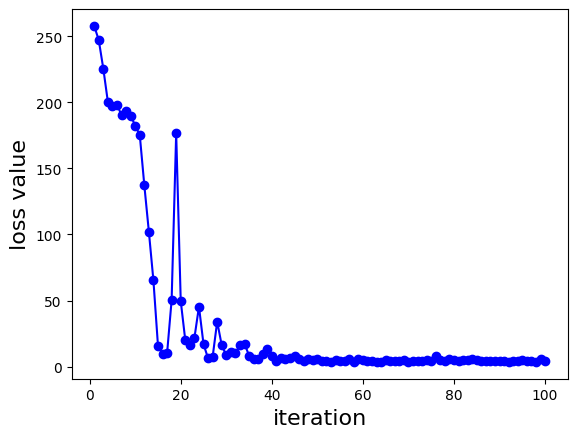

In [37]:
model.train(train, val, test)

In [ ]:
model.save_model('/home/sanskar-modi/personal_projects/ai_drug_discovery/trials/model_ic50')

# **Model Training (ec50)**

In [ ]:
drugs = df_ec50_train['mol_SMILES'].values
targets = df_ec50_train['target_info'].values
y = df_ec50_train['ec50'].values
train, val, test = utils.data_process(drugs, targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2],
                                random_seed = 1)
config = utils.generate_config(drug_encoding = drug_encoding,
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512],
                         train_epoch = 100,
                         LR = 0.001,
                         batch_size = 128,
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )
model = models.model_initialize(**config)
model.train(train, val, test)

In [ ]:
model.save_model('/home/sanskar-modi/personal_projects/ai_drug_discovery/trials/model_ec50')

# **Model Training (ki)**

In [ ]:
drugs = df_ki_train['mol_SMILES'].values
targets = df_ki_train['target_info'].values
y = df_ki_train['ki'].values
train, val, test = utils.data_process(drugs, targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2],
                                random_seed = 1)
config = utils.generate_config(drug_encoding = drug_encoding,
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512],
                         train_epoch = 100,
                         LR = 0.001,
                         batch_size = 128,
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )
model = models.model_initialize(**config)
model.train(train, val, test)

In [ ]:
model.save_model('/home/sanskar-modi/personal_projects/ai_drug_discovery/trials/model_ki')